# Social Media Analysis

## Overview

In this election year in the United States, your team will make use of an LLM to analyze what people on social media think of the two presidential candidates (Harris and Trump) on a range of election-relevant issues (e.g., immigration, the economy, the war in Gaza, the war in Ukraine, Medicare). You will do this by reading comments from Reddit and YouTube and asking the LLM how the commenter feels about your candidate and topics of interest. We will run the provided code (with your modifications) code each day to get a picture of the public's opinion on your candidate and issues and how it changes all the way to November 5, election day!

This problem, called [Feature-Based or Aspect-Based Sentiment Analysis](https://paperswithcode.com/task/aspect-based-sentiment-analysis#task-home), is a classic one in NLP, and has many use cases. Marketing firms, for exmaple, will use it to identify which aspects of their product people like and dislike.

### Your Responsibility

At minimum, you will be responsible for:
1. Modifying our data collection method (see "Data Collection" section)
2.  Writing prompts based on ours for a few topics of your choosing (see the "System prompts" section, and read through the previous sections for an explanation).
3.  Providing a brief justification of your methodology for both.

### Developing your Code


The code in this notebook makes use of a GPU, and needs at least 16GB vRAM to work. Fortunately, Rice has provided us with two ways to run your code - a VM with the needed resources and access to NOTS. Also, [Google CoLab](https://colab.research.google.com) offers a T4 GPU with 16GB for free, although there is a limit per user per day.

When developing and testnig your prompts, run your code using CoLab. Make sure you select the T4 runtime. You can do this by clicking the arrow next to "Connect" in the top right, selecting "Change Runtime Type", then "T4 GPU".

### Doing a full dataset run of your code


Google CoLab's free tier will disconnect you after a few hours, so it is best for short inference runs. This is good for testing your prompts, but will not do for running inference on the full dataset that you collect.

Starting on Friday, October 25th, and every 2 days thereafter, an assignment will be due on Gradescope called **Special LLM Assignment: Checkpoint "n"**. Submit your most recent version of this notebook to that assignment, and we will do a full dataset run of your code! Ensure that **all cells will run sequentially** without errors.

## API Setup



You will need access to various APIs in order to run the code.

The [Guide to API Access](https://docs.google.com/document/d/1oPmxtLhJEH_F1E-WXJtG1aXlyB5tZCestcXKdShSZdQ/edit?usp=sharing) will walk you through how to gain acces.

## Install and Import Dependencies

Run this code only if running this notebook on Google CoLab.

In [1]:
%pip install praw
%pip install peft
%pip install trl
%pip install bitsandbytes
%pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 8.2 MB/s eta 0:00:00


Run this code regardless of your environment.

In [2]:
from typing import Iterable
import matplotlib.pyplot as plt
import pandas as pd
import googleapiclient.discovery
import praw
import praw.models
from getpass import getpass
import itertools
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, PreTrainedModel, PreTrainedTokenizer, AutoConfig
from peft import AutoPeftModelForCausalLM
from getpass import getpass
import os
import torch
import time
import gc
import json

## Data Collection (MODIFY THIS)

The code in this section collects and formats all the data we will use from YouTube and Reddit.

The first 3 subsections (Connect to API Clients, Fetch YouTube Data, and Fetch Reddit Data) contain a host of utility functions that you will make use of to collect the data.

You will be responsible for modifying the "Put it all together and collect the data" section.

Follow the **Guide to API Access** in order to retrieve the API credentials that this function will prompt you for.

### Connect to API Clients

The code in these cells opens up a connection to the YouTube and Reddit APIs.

In [3]:
def connect_to_youtube():
    """Returns an API client for the YouTube Data API.

    e.g. youtube_client = connect_to_youtube()

    Pass this to any function that has a parameter called youtube_client.
    """


    return googleapiclient.discovery.build(
        "youtube", "v3", developerKey=prompt_unset_env("YOUTUBE_API_KEY", "Enter your YouTube API Key:")
    )


def connect_to_reddit():
    """Returns an API client for the Reddit API

    e.g. reddit_client = connect_to_reddit()

    Pass this to any function that has a paremeter called reddit_client.
    """


    return praw.Reddit(
        client_id=prompt_unset_env("REDDIT_CLIENT_ID", "Enter your Reddit client ID:"),
        client_secret=prompt_unset_env("REDDIT_CLIENT_SECRET", "Enter your Reddit client secret:"),
        username=prompt_unset_env("REDDIT_USERNAME", "Enter your Reddit username:"),
        password=prompt_unset_env("REDDIT_PASSWORD", "Enter your Reddit account password (the one you use to sign in):"),
        user_agent="COMP 540 Assignment 4",
    )

def prompt_unset_env(env_var: str, prompt: str):
    """
    Asks the user for env_var with the text prompt
    if os.environ[env_var] is unset.

    You should not need to call this function directly.
    """
    if env_var not in os.environ:
        os.environ[env_var] = getpass(prompt)
    return os.environ[env_var]


### Fetch YouTube data

#### Get most popular videos

The code in the cell below fetches the top "Trending" videos across YouTube. Use it to get a cross-section of the full range of topics discussed on YouTube.

Additionally, YouTube maintains a list of 30 or so "Categories", into which it sorts every video on the site. We can use them to limit the types of videos that the "Trending" list returns. For example, if we only want "News & Politics", we can call get_most_popular_youtube_videos(youtube_client, "25")

Provided is a function that gets the top n posts for the given category ID. In the docstring, there is a description of how to use the function.

In [4]:
YOUTUBE_CATEGORIES = {
    'Film & Animation': "1",
    'Autos & Vehicles': "2",
    'Music': "10",
    'Pets & Animals': "15",
    'Sports': "17",
    'Short Movies': "18",
    'Travel & Events': "19",
    'Gaming': "20",
    'Videoblogging': "21",
    'People & Blogs': "22",
    'Comedy': "34",
    'Entertainment': "24",
    'News & Politics': "25",
    'Howto & Style': "26",
    'Education': "27",
    'Science & Technology': "28",
    'Nonprofits & Activism': "29",
    'Movies': "30",
    'Anime/Animation': "31",
    'Action/Adventure': "32",
    'Classics': "33",
    'Documentary': "35",
    'Drama': "36",
    'Family': "37",
    'Foreign': "38",
    'Horror': "39",
    'Sci-Fi/Fantasy': "40",
    'Thriller': "41",
    'Shorts': "42",
    'Shows': "43",
    'Trailers': "44"
}

def get_most_popular_youtube_videos(youtube_client, category_id: str | None = None, n_videos: int=50, region_code: str = "US"):
  """
  Lists the n most popular videos on YouTube in the US for the given category ID.
  Videos are output as a raw dictionary.

  Parameters:
  - youtube_client: YouTube API client, retrieved from connect_to_youtube().
  - category_id: The Category ID to fetch the videos from. Categories & their associated IDs can be found in the YOUTUBE_CATEGORIES dictionary
  - n_videos: Number of videos to return. YouTube will return up to 175. Defaults to 50.
  - region_code: Region to pull videos from. Defaults to "US".

  Example:
    youtube_client = connect_to_youtube()
    category_id = YOUTUBE_CATEGORIES["News & Politics"]

    videos = get_most_popular_US_youtube_videos(youtube_client, category_id, n_videos=50)

    videos_df = create_videos_df(videos)
  )
  """

  result = []
  nextPageToken = None
  while n_videos > 0:
    response = youtube_client.videos().list(
      part="snippet",
      chart="mostPopular",
      maxResults=min(n_videos, 50),
      regionCode=region_code,
      videoCategoryId=category_id,
      pageToken=nextPageToken
    ).execute()
    result.extend(response["items"])
    if "nextPageToken" not in response:
      break
    nextPageToken = response["nextPageToken"]
    n_videos -= 50
  return result

#### Search YouTube

This function performs a search of the YouTube website - it effectively types something into the YouTube search bar with code.

You can use it to get results more specific to a topic of interest of yours.

In [5]:
def search_youtube(youtube_client, query: str, n_videos: int=50, region_code: str="US", order="relevance"):
    """Perform a search of the YouTube site.

    Parameters:
        youtube_client: YouTube API client, retrieved from connect_to_youtube().
        query: The query to search. Think of it as like typing into the YouTube search bar.
        n_videos: Number of videos to return. Defaults to 50.
        region_code: Region to search in. Defaults to "US"
        order: Order to return videos in. Defaults to "relevance". Other valid values are as follows:
            date - Resources are sorted in reverse chronological order based on the date they were created.
            rating - Resources are sorted from highest to lowest rating.
            relevance - Resources are sorted based on their relevance to the search query. This is the default value for this parameter.
            title - Resources are sorted alphabetically by title.
            videoCount - Channels are sorted in descending order of their number of uploaded videos.
            viewCount - Resources are sorted from highest to lowest number of views. For live broadcasts, videos are sorted by number of concurrent viewers while the broadcasts are ongoing.

    Example:
        youtube_client = connect_to_youtube()

        videos_about_harris = search_youtube(youtube_client, "Kamala Harris")

        videos_about_harris_df = create_videos_df(videos_about_harris)
    """


    result = []
    nextPageToken = None
    while n_videos > 0:
        response = youtube_client.search().list(
            part="snippet",
            q=query,
            order=order,
            maxResults=min(n_videos, 50),
            regionCode=region_code,
            pageToken=nextPageToken,
            type="video"
        ).execute()
        result.extend(response["items"])
        if "nextPageToken" not in response:
            break
        nextPageToken = response["nextPageToken"]
        n_videos -= 50
    return result

#### Get YouTube comments

In [6]:


def get_youtube_comments(youtube_client, video_id: str, n_comments: int=100):
  """Fetches the top n comments that are replies to the given YouTube video ID.

  Parameters:
    - youtube_client: YouTube API client, retrieved from connect_to_youtube().
    - video ID: The video ID to get the comments for

  Example:

  youtube_client = connect_to_youtube()
  example_video = search_youtube(youtube_client, "Donald Trump")[0]
  example_video_id = get_youtube_video_id(example_video)

  comments = get_youtube_comments(youtube_client, example_video_id)
  """

  result = []
  nextPageToken = None
  while n_comments > 0:
    response =  youtube_client.commentThreads().list(
      part="snippet,replies",
      maxResults=min(n_comments, 100),
      order="relevance",
      pageToken=nextPageToken,
      videoId=video_id
    ).execute()
    result.extend(response["items"])
    # Fewer than 100 responses: return early
    if nextPageToken not in response:
      return result
    nextPageToken = response["nextPageToken"]
    n_comments -= 100
  return result


#### Format YouTube data to Pandas

In [7]:
def create_youtube_videos_df(videos) -> pd.DataFrame:
  """
    Takes in the given videos from the YouTube API.
    Using them, creates the following dataframe:

    Columns:
    - id: YouTube video ID (index)
    - raw: Raw output from YouTube API
    - title: Video title
    - channel: Channel that posted the video

    Example:

      videos = get_most_popular_youtube_videos(<...>)

      videos_df = create_videos_df(youtube_client, videos)
  """
  # Videos dataframe
  df = pd.DataFrame(
    data={"raw": videos}
  )
  df["id"] = df.raw.apply(get_youtube_video_id)
  df.set_index("id", inplace=True)
  df["title"] = df.raw.apply(get_youtube_video_title)
  df["channel"] = df.raw.apply(get_youtube_video_channel)
  return df

def create_youtube_comments_df(youtube_client, videos, n_per_video: int=100) -> tuple[pd.DataFrame, pd.DataFrame]:
  """
   Takes in the given videos from the YouTube API.
   Fetches n_per_video commments for each video, and formats them
   into the following dataframe:

   Columns:
   - id: YouTube comment ID (index)
   - raw: Raw output from YouTube API
   - body: Comment text
   - author: Author that posted the comment
   - likes: Like count of comment
   - parent_id: ID of the comment that this comment is a reply to. pd.NA if it is a top-level comment

   Example:

    videos = get_most_popular_youtube_videos(<...>)

    comments_df = create_comments_df(youtube_client, videos, 100)
   """


  if isinstance(videos, pd.DataFrame):
    videos = [video["raw"] for video in videos]

  # Comments dataframe
  comments = {"raw": [], "video_id": []}
  for video in videos:
    video_id = get_youtube_video_id(video)
    try:
      video_comments = get_youtube_comments(youtube_client, video_id, n_comments=n_per_video)
    except googleapiclient.errors.HttpError:
      continue
    comments["raw"].extend(video_comments)
    comments["video_id"].extend([video_id] * len(video_comments))

  youtube_comments_df = pd.DataFrame(
    data=comments
  )
  youtube_comments_df["id"] = youtube_comments_df.raw.apply(get_youtube_comment_id)
  youtube_comments_df.set_index("id", inplace=True)
  youtube_comments_df["body"] = youtube_comments_df.raw.apply(get_youtube_comment_body)
  youtube_comments_df["author"] = youtube_comments_df.raw.apply(get_youtube_comment_author)
  youtube_comments_df["likes"] = youtube_comments_df.raw.apply(get_youtube_comment_likes)


  # Add replies to comments dataframe
  replies_raw = []
  for comment in comments["raw"]:
    for reply in get_youtube_comment_replies(comment):
      replies_raw.append(reply)

  replies_df = pd.DataFrame(
    data={"raw": replies_raw}
  )
  replies_df["id"] = replies_df.raw.apply(lambda x: x["id"])
  replies_df.set_index("id", inplace=True)
  replies_df["video_id"] = replies_df.raw.apply(lambda x: x["snippet"]["videoId"])
  replies_df["parent_id"] = replies_df.raw.apply(lambda x: x["snippet"]["parentId"])
  replies_df["body"] = replies_df.raw.apply(get_youtube_comment_reply_body)
  replies_df["author"] = replies_df.raw.apply(get_youtube_comment_reply_author)
  replies_df["likes"] = replies_df.raw.apply(get_youtube_comment_reply_likes)
  youtube_comments_df = pd.concat([youtube_comments_df, replies_df])

  return youtube_comments_df

def join_youtube_dfs(youtube_videos_df, youtube_comments_df):
  """Joins together the YouTube comments and posts.
  """
  youtube_comments_parents_joined = youtube_comments_df.join(youtube_comments_df, on="parent_id", rsuffix="_parent")
  return youtube_comments_parents_joined.join(youtube_videos_df, on="video_id", lsuffix="_comment", rsuffix="_video")


# The following functions are used by the create_youtube_df
# functions to extract data from YouTube. You likely won't use them directly.

def get_youtube_video_id(video):
  if isinstance(video["id"], str):
    return video["id"]
  else:
    return video["id"]["videoId"]

def get_youtube_video_title(video):
  return video["snippet"]["title"]

def get_youtube_video_channel(video):
  return video["snippet"]["channelTitle"]

def get_youtube_comment_body(comment):
  return comment["snippet"]["topLevelComment"]["snippet"]["textDisplay"]

def get_youtube_comment_replies(comment):
  try:
    return comment["replies"]["comments"]
  except KeyError:
    # No replies field in the comment... there must not be any replies.
    return []

def get_youtube_comment_reply_body(comment):
  return comment["snippet"]["textDisplay"]

def get_youtube_comment_author(comment):
  return comment["snippet"]["topLevelComment"]["snippet"]["authorDisplayName"]

def get_youtube_comment_reply_author(comment):
  return comment["snippet"]["authorDisplayName"]

def get_youtube_comment_likes(comment):
  return comment["snippet"]["topLevelComment"]["snippet"]["likeCount"]

def get_youtube_comment_reply_likes(comment):
  return comment["snippet"]["likeCount"]

def get_youtube_comment_id(comment):
  return comment["id"]

### Fetch Reddit data

#### Get posts

In [8]:
def search_reddit(reddit_client: praw.Reddit, query: str, n_posts: int=25, subreddit: str="all", time_filter="day"):
    """
    Performs a search of the Reddit site for query. This is like typing query into the search bar at the top of the site.

    Inputs:
    - reddit_client: The API client returned from connect_to_reddit()
    - query: The string to search the site for
    - n_posts: Number of posts to return. Defaults to 25
    - subreddit: The subreddit to search, without the /r/ prefix (e.g. to search /r/politics, should be "politics").
        Defaults to /r/all, which is a fake subreddit that displays all posts across the site.
    - time_filter: Limit your search to posts created within a certain time range.
        Can be one of: "all", "day", "hour", "month", "week", or "year" (default: "day")
    """
    return list(reddit_client.subreddit(subreddit).search(query=query, time_filter=time_filter, limit=n_posts))

In [9]:
def get_most_popular_reddit_posts(reddit_client: praw.Reddit, n_posts: int=25, subreddit: str="all", time_filter="day"):
    """
    Gets the most upvoted posts on Reddit.

    Inputs:
    - reddit_client: The API client returned from connect_to_reddit()
    - n_posts: Number of posts to return. Defaults to 25
    - subreddit: The subreddit to return posts from, without the /r/ prefix (e.g. to search /r/politics, should be "politics").
        Defaults to /r/all, which is a fake subreddit that displays all posts across the site.
    - time_filter: Limit to posts created within a certain time range.
        Can be one of: "all", "day", "hour", "month", "week", or "year" (default: "day")
    """
    return list(reddit_client.subreddit(subreddit).top(limit=n_posts, time_filter=time_filter))

#### Format Reddit data to Pandas

In [10]:
def create_reddit_posts_df(posts: Iterable[praw.models.Submission]) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Takes in an iterable (list, generator, set, etc) of Reddit posts and returns the following DataFrame:

    Columns:
        id: Post ID (index)
        likes: Upvote / downvote count of post
        title: Title of post
        body: Text of post
        subreddit: Subreddit where post was posted
        author: Username that wrote post
        published_timestamp: Time when the post was published.
    """


    post_data = {
        "id": [],
        "likes": [],
        "title": [],
        "body": [],
        "subreddit": [],
        "author": [],
        "published_timestamp": []
    }

    for submission in posts:
        post_data["id"].append(submission.id)
        post_data["published_timestamp"].append(submission.created)
        post_data["author"].append(submission.author)
        post_data["likes"].append(submission.score)
        post_data["body"].append(submission.selftext)
        post_data["title"].append(submission.title)
        post_data["subreddit"].append(submission.subreddit.display_name)


    return pd.DataFrame(post_data).set_index("id")

def create_reddit_comments_df(posts: Iterable[praw.models.Submission], comment_limit=10) -> pd.DataFrame:
    """
    Takes in an iterable (list, generator, set, etc) of Reddit posts and returns a DataFrame
    containing data about the comments.

    Columns:
        id: Comment ID (index)
        post_id: ID of the post this comment is a reply to
        likes: Upvote / downvote count of commment
        body: Text of comment
        subreddit: Subreddit where post was posted
        author: Username that wrote comment
        order_returned: 0 if 1st comment retrieved from the post, 1 if 2nd comment, etc
    """
    comment_data = {
        "id": [],
        "post_id": [],
        "likes": [],
        "author": [],
        "body": [],
        "author": [],
        "order_returned": [],
    }
    for submission in posts:
        submission.comments.replace_more(limit=0)
        for idx, comment in enumerate(submission.comments):
            if idx >= comment_limit:
                break
            comment_data["order_returned"].append(idx)
            comment_data["id"].append(comment.id)
            comment_data["post_id"].append(submission.id)
            comment_data["likes"].append(comment.score)
            comment_data["author"].append(comment.author)
            comment_data["body"].append(comment.body)
    return pd.DataFrame(comment_data).set_index("id")

def join_reddit_dfs(reddit_posts_df, reddit_comments_df):
    """Joins together the comments and posts."""
    return reddit_comments_df.join(reddit_posts_df, on="post_id", rsuffix="_post")


### Put it all together and collect the data (MODIFY THIS)

This code takes all of the utility functions for data collection in the cells above and uses them to collect the data we want from YouTube and Reddit.

Modify this to get data relevant to topics you are interested in. We've provided you with code that, on each site:
1. Performs searches for Kamala Harris and Donald Trump
2. Pulls in the top 5 most popular posts sitewide
3. Pulls in the top 5 most popular political posts on each site

You might consider:
1. Modifying the search keywords or adding more
2. Pulling in a larger number of the most popular posts sitewide
3. Analyzing different categories (YouTube) or subreddits (Reddit)

You should aim for a data collection method that:
1. Filters out non-political content - we don't want to waste our time running inference on this!
2. Gets a representative sample of the users of the site - we want to gauge what everyone thinks, not just one small community of users.

In [43]:
reddit_client = connect_to_reddit()

# NOTE: For each query, we only get 5 posts.
# This is so that, when you run this cell for the first time,
# it completes in a reasonable amount of time.
# We will almost certainly want far more data than this!
# MODIFY THIS PART OF THE CODE

# We search for Harris and Trump - are there more interesting things you can search for?
harris_reddit_posts = search_reddit(reddit_client, "Kamala Harris", n_posts=5)
trump_reddit_posts = search_reddit(reddit_client, "Donald Trump", n_posts=5)
# We get the 5 most upvoted posts sitewide for the day - should we get more? Less?
popular_reddit_posts = get_most_popular_reddit_posts(reddit_client, n_posts=5)
# We check /r/politics for the most popular posts as well. Are there other subreddits you are
# interested in analyzing a large number of posts from?
# https://www.reddit.com/best/communities/1/ is a good place to find interesting subreddits.
popular_reddit_posts_on_r_politics = get_most_popular_reddit_posts(reddit_client, n_posts=5, subreddit="politics")

posts_combined = harris_reddit_posts + trump_reddit_posts + popular_reddit_posts + popular_reddit_posts_on_r_politics

# END MODIFY THIS PART OF THE CODE

reddit_posts_df = create_reddit_posts_df(posts_combined)
reddit_comments_df = create_reddit_comments_df(posts_combined, comment_limit=10) # do we want to fetch more comments?
reddit_df = join_reddit_dfs(reddit_posts_df, reddit_comments_df)

Enter your Reddit client ID:··········
Enter your Reddit client secret:··········
Enter your Reddit username:··········
Enter your Reddit account password (the one you use to sign in):··········


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

In [44]:
# Connect clients
youtube_client = connect_to_youtube()

# NOTE: For each query, we only get 5 posts.
# This is so that, when you run this cell for the first time,
# it completes in a reasonable amount of time.
# We will almost certainly want far more data than this!
# MODIFY THIS PART OF THE CODE


# Get the top 50 most popular YouTube videos for the News & Politics category
# Also search for Harris and Trump

harris_youtube_videos = search_youtube(youtube_client, "Kamala Harris", n_videos=5)
trump_youtube_videos = search_youtube(youtube_client, "Donald Trump", n_videos=5)
popular_youtube_videos_sitewide = get_most_popular_youtube_videos(youtube_client, n_videos=5)
# Are there other interesting category IDs to analyze?
category_id = YOUTUBE_CATEGORIES["News & Politics"]
popular_youtube_politics_videos = get_most_popular_youtube_videos(youtube_client, category_id, n_videos=5)

videos_combined = harris_youtube_videos + trump_youtube_videos + popular_youtube_videos_sitewide + popular_youtube_politics_videos

youtube_videos_df = create_youtube_videos_df(videos_combined)
youtube_comments_df = create_youtube_comments_df(youtube_client, videos_combined, n_per_video=2) # do we want to fetch more comments?
youtube_df = join_youtube_dfs(youtube_videos_df, youtube_comments_df)

Enter your YouTube API Key:··········


In [42]:
# Should you accidentally enter the wrong key for anything, run the corresponding line below:
del os.environ["YOUTUBE_API_KEY"]
del os.environ["REDDIT_CLIENT_ID"]
del os.environ["REDDIT_CLIENT_SECRET"]
del os.environ["REDDIT_USERNAME"]
del os.environ["REDDIT_PASSWORD"]

## Load Model

We'll be using the newly released [Meta Llama 3.2 Instruct model with 3 billion parameters](https://huggingface.co/meta-llama/Llama-3.2-3B) for our analysis. This model is incredibly powerful for how small it is, and, most importantly, extremely fast.

Run the below to log in to HuggingFace and load the model onto your GPU, after you have completed the instructions in the **Guide to API Access**. Enter your token when prompted.


In [51]:
HF_TOKEN = prompt_unset_env("HF_TOKEN", "Enter your HuggingFace token:")
HF_CACHE = os.environ.get("HF_CACHE", None)

HF_MODEL_NAME="meta-llama/Llama-3.2-3B-Instruct"

# Here we compress our model with 8-bit "quantization".
# You can think of quantization as rounding the model's
# parameters, which are stored as 32-bit floats, to 8 bits.
# This saves a lot of space on our GPU!
quantization_config = BitsAndBytesConfig(
  load_in_8bit=True,
  bnb_4bit_compute_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(
  HF_MODEL_NAME,
  quantization_config=quantization_config,
  cache_dir=HF_CACHE
)

# Notice the 'Causal' ain the constructor.
# Llama is a 'Causal' LM, meaning it predicts the next token given only the previous tokens.
# Some 'masked' LMs like BERT can predict a token in the middle of a sentence.
model = AutoModelForCausalLM.from_pretrained(
  HF_MODEL_NAME,
  quantization_config=quantization_config,
  # Let HuggingFace decide which device to put our model on.
  # This will efficiently share CPU and GPU resources.
  device_map="auto",
  token=HF_TOKEN
)

# REPLACE MODEL LOAD CODE ABOVE WITH THE FOLLOWING IF FINE-TUNING (OPTIONAL)
# model = AutoPeftModelForCausalLM.from_pretrained(
#   "lora",
#   cache_dir=HF_CACHE,
#   quantization_config=quantization_config,
#   device_map="auto"
# )


Enter your HuggingFace token:··········


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [ ]:
del os.environ['HF_TOKEN']

## Prompt Format for Instruct models

The LLMs that you have studied so far simply predict the most likely next token based on the previous tokens in the sequence. These models do not lend themselves well to instruction-following. For example, in the training corpus of a normal LLM, "Write a letter to my mom" is not likely to precede the text "Dear mom". So, it is more likely to complete the sentence with text like "for Mother's day".

Instruct-tuned models have gone through an extra training step where they are fed a series of instructions paired with desired outputs. For example, as far as we are aware, Meta Llama was trained on a corpus of text which looked like this:

  
  > <|begin_of_text|>
  >
  > <|start_header_id|>system<|end_header_id|>
  >
  > You will be given a question. Answer it like you are a cowboy.
  >
  > <|eot_id|>
  >
  > <|start_header_id|>user<|end_header_id|>
  >
  > What is a polite way to say hello to your friend?
  >
  > <|eot_id|>
  >
  > <|start_header_id|>assistant<|end_header_id|>
  >
  > Howdy, partner!
  >
  > <|eos_token|>

This is documented in Meta Llama's [Model Card](https://www.llama.com/docs/model-cards-and-prompt-formats/meta-llama-3/)

The text under `<|start_header_id|>system<|end_header_id|>` is known as the **system prompt**. The attention layer of the model is trained such that text in the system prompt always has a high weight. It is useful for information that the model needs to not forget, even through a long prompt.

The text under `<|start_header_id|>user<|end_header_id|>` is the **user prompt**, which receives no special treatment.

The text under `<|start_header_id|>assistant<|end_header_id|>` is the text that the model is supposed to generate.

These Instruct models will be more useful to us, since we want them to perform complex instructions rather than simple text completions. The function below formats text into a system and user prompt.

In [52]:
LLAMA_INSTRUCT_PROMPT_FORMAT = """<|start_header_id|>system<|end_header_id|>
  {system_prompt}<|eot_id|>
  <|start_header_id|>user<|end_header_id|>
  {user_prompt}<|eot_id|><|start_header_id|>assistant<|end_header_id|>""" # End after assistant header so that the first token predicted will be the model's response.

def format_instruct(system_prompt: str, user_prompt: str):
  """Formats the system prompt and the user prompt into a single string usable by meta llama."""
  return LLAMA_INSTRUCT_PROMPT_FORMAT.format(
    system_prompt=system_prompt,
    user_prompt=user_prompt
  )
def get_output_from_instruct(output_raw: str):
  """If an LLM was prompted from the Instruct format, get the text that was generated
  by the model. (specifically, between the assistant header and the EOS token)"""
  return output_raw.split("assistant<|end_header_id|>")[1] \
    .split(tokenizer.eos_token)[0]


## Inference Code

This code is used to run prompts through the model. It takes in a batch (group) of prompts as strings and runs inference on them.

This particular function is important to understand, so here is a breakdown:

- 1 ) The prompt batch is tokenized (converted to tensor embeddings) using the tokenizer
    - 1.1 ) All items in the batch must be the same length.
        This allows for high-speed parallel processing of the batches on the GPU.
        In order to make the prompts the same length,
        we can add "padding" tokens which the model will ignore.
        In this case, we add EOS tokens on the left until all
        prompts are the same length. We add them on the left
        instead of the right so that there isn't an EOS token between
        the prompt and the model's output
- 2 ) The token embeddings are run through the model's forward function
    - 2.1 ) An upper limit on the number of new tokens is set. This is a failsafe in case the model gets stuck in a loop and fails to ever generate an EOS token. Without it, generation would just carry on forever!
- 3 ) The token output of the model's forward function is decoded back into strings using the tokenizer

In [53]:
def inference(model: PreTrainedModel, tokenizer: PreTrainedTokenizer, prompt_batch: list[str], max_new_tokens: int=196, verbose: bool=False) -> list[str]:
  """Tokenizes prompt_batch using tokenizer and runs them through model all at once.
  Returns the output from the model as a list of strings, where inference(...)[i] == output from prompt_batch[i]

  Parameters:
    - model: LLM to run inference on (loaded from HuggingFace)
    - tokenizer: Tokenizer to encode inputs with (loaded from HuggingFace)
    - prompt_batch: Batch of prompts to run inference on
    - max_new_tokens: Maximum number of new tokens to generate
    - verbose: Set to True for additional print messages

  Example:

    model = AutoModelForCausalLM.from_pretrained(...)
    tokenizer = AutoTokenizer.from_pretrained(...)

    output = inference(model, tokenizer, ["one plus one equals"]) // ["<|bos_token|>one plus one equals two<|eot_id|>"]
  """
  with torch.no_grad():
      # 1) Encode prompts as tensors with the tokenizer
      # 1.1) Add padding
      tokenizer.pad_token = tokenizer.eos_token
      tokenizer.padding_side = "left"
      # Now, tokenize the inputs
      inputs = tokenizer(
        prompt_batch,
        return_tensors = "pt",

        padding=True,
      )
      if verbose:
        print("In token shape", inputs["input_ids"].shape)
        print("Memory usage before moving tensors to CUDA: ", torch.cuda.memory_summary())

      # Move the inputs to the same device as the model.
      inputs = inputs.to(model.device)

      if verbose:
        print("Memory usage after moving tensors to CUDA: ", torch.cuda.memory_summary())

      # 2) Generate output tokens
      outputs = model.generate(
        **inputs,
        # 2.1) Set an upper bound on the number of new tokens
        max_new_tokens=max_new_tokens
      )
      if verbose:
        print("Out token shape", outputs.shape)
        print("Memory usage after inference moving to device: ", torch.cuda.memory_summary())
      # 3) Decode the output tokens back into strings.
      return tokenizer.batch_decode(outputs)

### Other inference code

#### Code for batching prompts

The description of the previous function mentioned running prompts in batches. Batching prompts has a significant (up to 10x) speed improvement because:

1) It allows for many prompts to be processed in parallel rather than one at a time
2) If 2 prompts in a batch share a prefix, the model will cache the K and V self-attention components for those prefixes so that they are only computed once across the whole batch. This is useful when we are processing hundreds of prompts with the same system prompt.

However, the entire batch needs to be moved over to the GPU at once, so there is an upper limit to how many tokens we can fit into a single batch.

These functions break a list of prompts into batches, cramming as many as possible onto our GPU as possible. You likely won't call either of these functions directly.

In [54]:
def get_num_tokens(tokenizer: PreTrainedTokenizer, seq: str):
  """Returns the number of tokens in the sequence."""
  return tokenizer(seq, return_tensors="pt")["input_ids"].shape[1]

def maximum_size_batches(tokenizer, prompts: list[str], max_tokens_per_batch: int, max_new_tokens: int = 0) -> list[list[str]]:
  """
  Separates a list of prompts into a list of lists, where each inner list is a batch.
  The number of tokens in each batch will not exceed max_tokens_per_batch.
  """
  batches = []
  curr_batch = []
  max_tok_count_curr_batch = float("-inf")
  for prompt in prompts:
    prompt_tok_count = get_num_tokens(tokenizer, prompt)
    max_tok_count_curr_batch = max(prompt_tok_count, max_tok_count_curr_batch)
    if (max_tok_count_curr_batch + max_new_tokens) * (len(curr_batch) + 1) > max_tokens_per_batch:
      batches.append(curr_batch)
      curr_batch = []
      max_tok_count_curr_batch = prompt_tok_count
    curr_batch.append(prompt)
  batches.append(curr_batch)
  return batches

#### Pulling it all together: Code to run inference on batches in a loop

This function puts all of the pieces together. It takes in a Pandas dataframe with the explained column format, and runs inference on each row, batching together the prompts. You will likely call it yourself to run inference. Later on, there is an example wheere we have done so which you can follow.

In [55]:
# Only process as many tokens per batch as will fit on the GPU.
# On CoLab, this is unfortunately only about 10,000.
# The VM can handle up to 40,000!
MAX_TOKENS_PER_BATCH=os.environ.get("MAX_TOKENS_PER_BATCH", 10e3)

def llama_instruct_inference_on_df_for_topic(model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df: pd.DataFrame, topic: str, max_new_tokens: int=196):
  """
  Using model and tokenizer, run inference on each row in the dataframe.
  For each row, the user prompt is df["user_prompt"],
  and the system prompt is df["system_prompt {topic}"].
  Saves the inference result to df ["inference_output {topic}"].

  Example:
    youtube_df = join_youtube_dfs(...)

    topic = "Kamala Harris"

    youtube_df["user_prompt"] =  youtube_df.apply(get_youtube_user_prompt, axis=1)
    youtube_df["system_prompt " + topic] = SENTIMENT_TOPICS_AND_PROMPTS[topic]

    llama_instruct_inference_on_df_for_topic(model, tokenizer, topic)
  """
  print(f"Starting inference for topic {topic}")
  start = time.time()

  df[f"full_prompt {topic}"] = df.apply(
    lambda row: format_instruct(row[f"system_prompt {topic}"], row["user_prompt"]),
    axis=1
  )

  output = []
  batches = maximum_size_batches(tokenizer, df[f"full_prompt {topic}"].to_list(), MAX_TOKENS_PER_BATCH, max_new_tokens)
  print("Batch lengths", [len(batch) for batch in batches])
  for batch_num, batch in enumerate(batches):
    print("Batch", batch_num, "Batch length", len(batch))
    output.extend(
      get_output_from_instruct(x)
      for x in inference(
        model,
        tokenizer,
        batch,
        max_new_tokens
      )
    )

    gc.collect()
    torch.cuda.empty_cache()

  df[f"inference_output {topic}"] = output

  print("Inference time: ", time.time() - start)



## Utility functions for inference postprocessing

You don't need to understand these, unless you want to edit the output format in the prompt.

In [56]:
def extract_key_from_json_column(key):
  """Higher-order function.

  Returns a function that, when applied to a Pandas series,
  loads the series as JSON and extracts the given key from the JSON object.
  """
  return lambda x: get_key_from_json_string(x, key)

def get_key_from_json_string(json_string, key):
  """Return the value associated with key in the JSOn object represented in json_string.

  If there is a missing end curly bracket, it will still be parsed.
  """

  try:
    return json.loads(json_string)[key]
  except json.decoder.JSONDecodeError:
    # Try adding a closing bracket (model loves to forget this)
    try:
      return json.loads(json_string + "}")[key]
    except:
      print("Model output bad JSON", json_string)
      return pd.NA
  except KeyError as e:
    print(e)

def extract_sentiment_from_inference_output(df: pd.DataFrame, topic: str):
  """
  Given a dataframe that has been run through using llama_instruct_inference_on_df_for_topic,
  extract the sentiment, explanation, and confidence scores from the output of the inference for topic
  and place them in separate columns.

  The sentiment will be put in a column called "{topic}". The explanation will be put in a column called "explanation {topic}".
  The confidence score will be put in a column called "confidence {topic}"
  """


  inference_output_for_topic = df[f"inference_output {topic}"]
  df[topic] = inference_output_for_topic.apply(extract_key_from_json_column("sentiment"))
  df[f"explanation {topic}"] = inference_output_for_topic.apply(extract_key_from_json_column("explanation"))
  df[f"confidence {topic}"] = inference_output_for_topic.apply(extract_key_from_json_column("confidence"))

## Plot inference output

You will use these functions to plot the output after you've run inference on your topics.

In [57]:
def plot_sentiment_likes_by_topic(df):
    """Creates a bar plot such that:

    - There is one group of bars per topic in SENTIMENT_TOPICS_AND_PROMPTS
    - There is a bar for each sentiment type ("Positive", "Negative", or "Neutral")
    - The height of each bar is the number of likes on each post.


    Example:
        # Run inference and extract output
        llama_instruct_inference_on_df_for_topic(reddit_df, "Kamala Harris")
        extract_sentiment_from_inference_output(reddit_df, "Kamala Harris")

        # Plot sentiment likes by topic
        plot_sentiment_likes_by_topic(reddit_df)
        plt.savefig("reddit_df_kamala_harris_sentiment.pdf")
    """
    # Ignore not defined warning here: we define SENTIMENT_TOPICS_AND_PROMPTS later
    TOPICS_IN_DF = [topic for topic in SENTIMENT_TOPICS_AND_PROMPTS if topic in df]

    likes_by_topic_by_sentiment = df.melt(id_vars="likes", value_vars=TOPICS_IN_DF, var_name="Topic", value_name="Sentiment").dropna()

    like_sum_by_sentiment_by_topic = likes_by_topic_by_sentiment \
    .groupby(["Sentiment", "Topic"])["likes"] \
    .sum() \
    .reset_index() \
    .pivot(index="Topic", columns="Sentiment", values="likes") \

    like_sum_by_sentiment_by_topic[like_sum_by_sentiment_by_topic.columns.intersection(["Negative", "Neutral", "Positive"])] \
    .plot(kind="bar")


In [ ]:
def plot_sentiment_comment_count_by_topic(df):
    """Creates a bar plot such that:

    - There is one group of bars per topic in SENTIMENT_TOPICS_AND_PROMPTS
    - There is a bar for each sentiment type ("Positive", "Negative", or "Neutral")
    - The height of each bar is the number of comments on each post.


    Example:
        # Run inference and extract output
        llama_instruct_inference_on_df_for_topic(reddit_df, "Kamala Harris")
        extract_sentiment_from_inference_output(reddit_df, "Kamala Harris")

        # Plot sentiment likes by topic
        plot_sentiment_comment_count_by_topic(reddit_df)
        plt.savefig("reddit_df_kamala_harris_sentiment.pdf")
    """
    # Ignore not defined warning here: we define SENTIMENT_TOPICS_AND_PROMPTS later
    TOPICS_IN_DF = [topic for topic in SENTIMENT_TOPICS_AND_PROMPTS if topic in df]

    comments_by_topic_by_sentiment = df.melt(value_vars=TOPICS_IN_DF, var_name="Topic", value_name="Sentiment").dropna()

    comment_count_by_sentiment_by_topic = comments_by_topic_by_sentiment \
        .groupby(["Sentiment", "Topic"]) \
        .size() \
        .to_frame("Comment count") \
        .reset_index() \
        .pivot(index="Topic", columns="Sentiment", values="Comment count")

    comment_count_by_sentiment_by_topic[comment_count_by_sentiment_by_topic.columns.intersection(["Negative", "Neutral", "Positive"])] \
    .plot(kind="bar")

## Sample user prompts

We'll pass the actual text of the posts in as the user prompt, and save the instructions for the system prompt so that the system prompt always stays in context.

We've provided you with some sample user prompts to use. Use them, or modify them if you like.


In [58]:
YOUTUBE_USER_PROMPT_TEMPLATE = """
Platform: YouTube
Channel that posted video: {video_channel}

Video title: {video_title}
{parent_comment}
Comment to analyze:

{comment_author}: {comment}
"""

def get_youtube_user_prompt(row):
  """
  Formats YOUTUBE_USER_PROMPT_TEMPLATE to work with the given Pandas row.
  Row is assumed to be part of a dataframe with the following columns:

  body: Text of comment
  author: Author of comment
  title: Title of video the comment is on
  channel: Channel that posted the video that the comment is on
  author_parent: Author of the comment that this comment is a reply to
  body_parent: Text of the comment that this comment is a reply to

  The youtube_df you are provided works with this function.
  """
  if not pd.isna(row.author_parent) and not pd.isna(row.body_parent):
    parent_comment = f"\nComment is a reply to {row.author_parent}: {row.body_parent}\n"
  else:
    parent_comment = ""
  return YOUTUBE_USER_PROMPT_TEMPLATE.format(
    video_channel=row.channel,
    video_title=row.title,
    parent_comment=parent_comment,
    comment_author=row.author,
    comment=row.body
  )

In [59]:
REDDIT_USER_PROMPT_TEMPLATE = """
Platform: Reddit
Post:
{post_author}: {title}
{body_post}

Comment to analyze:
{comment_author}: {comment}
"""

def get_reddit_user_prompt(row):
    """
    Formats REDDIT_USER_PROMPT_TEMPLATE to work with the given Pandas row.
    Row is assumed to be part of a dataframe with the following columns:

    body: Text of comment
    author: Author of comment
    title: Title of post the comment is on
    author_post: Author of the post that this comment is a reply to
    body_post: Text of the post that this comment is a reply to

    The reddit_df you are provided works with this function.
    """
    return REDDIT_USER_PROMPT_TEMPLATE.format(
        post_author=row.author_post,
        title=row.title,
        body_post=row.body_post,
        comment_author=row.author,
        comment=row.body
    )

## System prompts (YOUR CODE GOES HERE)

The dictionary below contains a list of topics to create prompts for. We have provided you with 4 example prompts that have worked well for us, each following different strategies.

These approaches, and some others, are described [on Wikipedia](https://en.wikipedia.org/wiki/Prompt_engineering) in more detail.

### Breakdown of a few important lines in each prompt



> You are given a social media post and a comment to analyze.

It is important to provide some context to the model so that it knows what it is looking at.

> "explanation": "...",
> "confidence": 0-5


Telling the model to output a "confidence" score and an "explanation" actually makes it more likely to make the correct assessment! It also gives us insights on, if the model makes a mistake, why.

> Respond only with the JSON. Do not respond with anything else.

This line (almost) ensures that the model will output its response in JSON, and exclude any boilerplate (text like "Here is the JSON object you asked for!") It isn't perfect, though - the model is unfortunately still prone to errors.

You may change the model's output format if you like, but note that you'll need to edit the code that parses the output.

This line appears last because it is the most important instruction - if the model outputs sometihng else, then we cannot read its response!

### Your task

Your task is to adapt the prompts we have provided. First, under the "Try it!" section, run a few of our example prompts by changing the TOPIC variable to one of the topics we have provided prompts for. Observe the strengths and weaknesses of each prompt technique.

Using your preferred prompting technique, and improving on ours, write prompts that analyze:
- Sentiment towards Trump and Harris, in general (TOPIC="Donald Trump" or TOPIC="Kamala Harris")
- Sentiment towards Trump and Harris's stances on 2-3 topics of your choosing (can be immigration & the economy like we did, or any other political topic of your choice.)

Importantly, note that these prompts sort sentiment into three categories: "Positive", "Negative", or "Neutral". Your code will work with our code as long as the model sorts sentiment into one of these buckets, as well as one extra column for N/A or Not Mentioned (can be named anything, we ignore this.)

### Prompts (MODIFY THESE!)

In [60]:
SENTIMENT_TOPICS_AND_PROMPTS = {
    # Basic prompt: Fast, but model is mistake-prone
    "Donald Trump": """
        You are given a social media post and a comment to analyze.
        Determine the comenter's sentiment toward Donald Trump, if he is mentioned.
        Provide the output in the specified dictionary format.

        Respond with a JSON object, like:
        {
            "sentiment": "Positive", "Negative", "Neutral", or "Not Mentioned",
            "confidence": 0-5,
            "explanation": "..."
        }

        Respond only with the JSON. Do not respond with anything else.
    """,

    # "One-shot" prompt: give the model one example to follow
    # Has a nice balance between accuracy and performance,
    # but does not give many examples
    "Donald Trump and immigration": """
        You are given a social media post and a comment to analyze.
        Determine the comenter's sentiment toward Donald Trump's stance on immigration,
        if mentioned.

        EXAMPLE:
        Comment:
        sample_user: Vote Trump! Save our border!

        Output:
        {
            "sentiment": "Positive",
            "confidence": 3,
            "explanation": "The commenter encourages people to vote for Trump, purporting that he will handle the border and thereby immigration well".
        }

        Respond with a JSON object, like:
        {
            "sentiment": "Positive", "Negative", "Neutral", or "Not Mentioned",
            "confidence": 0-5,
            "explanation": "..."
        }

        Respond only with the JSON. Do not respond with anything else.
    """,

    # Few-shot: give the model several examples to follow.
    # This allows you to tell the model how to handle a number of edge cases.
    # This has the highest accuracy, but has a lot of tokens,
    # which will have an impact on performance.
    "Donald Trump and the economy": """
        You are given a social media post and a comment to analyze.
        Determine the comenter's sentiment toward Donald Trump's stance on the economy,
        if mentioned.

        EXAMPLE:
        Comment:
        sample_user_1: Joe Biden and Kamala Harris caused this inflation crisis!

        Output:
        {
            "sentiment": "Not Mentioned",
            "confidence": 2,
            "explanation": "While the comment does mention the economy (inflation) in a negative way, and states that it was caused by Harris, Trump's rival in the 2024 election, it does not directly mention Trump."
        }

        EXAMPLE:
        Comment:
        sample_user_2: Trump's tariffs will effectively be a $4000/yr sales tax hike. Do you want that for our country?

        Output:
        {
            "sentiment": "Negative",
            "confidence": 4,
            "explanation": "The comment criticizes Trump's tariffs, implying that it will negatively affect the economy."
        }

        EXAMPLE:
        Comment:
        sample_user_3: TRUMP 2024!! MAKE AMERICA GREAT AGAIN!!

        Output:
        {
            "sentiment": "Not Mentioned",
            "confidence": 5,
            "explanation": "The comment does mention Trump, but not the economy."
        }

        EXAMPLE:
        Ckmment:
        sample_user_4: I'm not sure what Trump's tariffs will do to the economy, but it will be interesting to see it play out!

        Output:
        {
            "sentiment": "Neutral",
            "confidence": 5,
            "explanation": "The comment talks about Trump's economic policy (tarrifs), but does not make a judgement about them."
        }

        Respond only with the JSON. Do not respond with anything else.
    """,
    # Meta Llama's "knowledge cutoff" is December 2023.
    # That means its training set contains only information from before then.
    # Kamala Harris was not a candidate for the 2024 election until July 2024!
    # So, adding a small explanation of who Harris is helps a lot.
    "Kamala Harris": """

        Kamala Harris is the Democratic party's nominee for President during the 2024 election.
        She is currently serving as Vice President of the United States
        and won the nomination after Joe Biden dropped out of the race.

        You are given a social media post and a comment to analyze.
        Determine the comenter's sentiment toward Kamala Harris, if she is mentioned.
        Provide the output in the specified dictionary format.

        Respond with a JSON object, like:
        {
            "sentiment": "Positive", "Negative", "Neutral", or "Not Mentioned",
            "confidence": 0-5,
            "explanation": "..."
        }

        Respond only with the JSON. Do not respond with anything else.
    """,
    # Chain-of-Thought reasoning: outline a thought process
    # for the model to follow. Have the model output it
    # before a judgement so that the chain of thought is in its context.
    "Kamala Harris and the economy": """

        Kamala Harris is the Democratic party's nominee for President during the 2024 election.
        She is currently serving as Vice President of the United States
        and won the nomination after Joe Biden dropped out of the race.

        You are given a social media post and a comment to analyze.
        Determine the comenter's sentiment toward Kamala Harris's stance on the economy,
        if she is mentioned. Respond with a JSON object. Reason about this by outlining a logical Chain of thought.

        EXAMPLE:
        Post:
        US consumers see higher long-run inflation, rising delinquency risk

        Comment:
        sample_user: Do not vote Harris! She caused this

        OUTPUT:
        {
            "Chain of thought": "Comment advises people not to vote for Harris > comment says she caused 'this' > 'this' likely refers to the economic issues referenced in the post > commenter feels Negative towards Kamala Harris'  economy",
            "sentiment": "Negative",
            "confidence": 5,
            "explanation": "Comment encourages readers to not vote for Harris, claiming she caused the economic problems referenced in the post".
        }

        EXAMPLE:
        Post:
        Kamala Harris up in the polls

        Comment:
        sample_user: Go queen!

        OUTPUT:
        {
            "Chain of thought": "There is no reference to the economy > Comment does not mention Harris and the economy",
            "sentiment": "N/A",
            "confidence": 5,
            "explanation": "Although the comment supports Harris, the comment does not support the economy".
        }

        Your Chain of thought should end in one of two conclusions:

        1. "commenter feels <Positive|Negative|Neutral> toward Kamala Harris's stance on the economy"

        "sentiment" should be the same as what you selected for <Positive|Negative|Neutral> in this case.

        2. "comment does not mention Kamala Harris' stance on the economy"

        "sentiment" should be "N/A" in this case.

        Only analyze the commenter's sentiment towards Kamala Harris' stance on the economy. Do not respond with the sentiment
        towards Trump or any other topic. Ensure "Chain of Thought" only ends in one of these two conclusions.


        Respond with a JSON object, like:
        {
            "Chain of thought": "..."
            "sentiment": "Positive", "Negative", "Neutral", or "N/A",
            "confidence": 0-5,
            "explanation": "...".
        }

        Respond only with the JSON. Do not respond with anything else.""",

        # YOUR CODE HERE: Analyze a topic of your choice by creating a new key-value pair, like:
        "<YOUR TOPIC HERE>": "<YOUR SYSTEM PROMPT HERE>"
}

# This code will match up each prompt with its
# corresponding entry in each dataframe. Run it each time you
# change your prompts.
for topic, prompt in SENTIMENT_TOPICS_AND_PROMPTS.items():
    youtube_df[f"system_prompt {topic}"] = prompt
    reddit_df[f"system_prompt {topic}"] = prompt
youtube_df["user_prompt"] = youtube_df.apply(get_youtube_user_prompt, axis=1)
reddit_df["user_prompt"] = reddit_df.apply(get_reddit_user_prompt, axis=1)


### Try it!

Try our prompts, or your own, by runing the following two cells. Read through the model's output to see what it got right and wrong, and use that information to improve your own prompts.

In [61]:
TOPIC = "Kamala Harris and the economy"
TRY_DF = reddit_df[:10] # or youtube_df, also try using different slices (e.g. [10:20])

llama_instruct_inference_on_df_for_topic(model, tokenizer, TRY_DF, TOPIC)
extract_sentiment_from_inference_output(TRY_DF, TOPIC)
pd.set_option("display.max_colwidth", None)
TRY_DF[["body", TOPIC, f"explanation {TOPIC}", f"inference_output {TOPIC}"]]

<ipython-input-55-a7e86903e469>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"full_prompt {topic}"] = df.apply(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Starting inference for topic Kamala Harris and the economy
Batch lengths [10]
Batch 0 Batch length 10
Inference time:  47.607738971710205


<ipython-input-55-a7e86903e469>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"inference_output {topic}"] = output
<ipython-input-56-7278dafb8a4f>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[topic] = inference_output_for_topic.apply(extract_key_from_json_column("sentiment"))
<ipython-input-56-7278dafb8a4f>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

,body,Kamala Harris and the economy,explanation Kamala Harris and the economy,inference_output Kamala Harris and the economy
id,,,,
ltab0ra,>[***r/Music***](https://new.reddit.com/r/music/) ***officially endorses Insane Clown Posse***,N/A,"Comment is about music and endorsement, not about Kamala Harris' stance on the economy","\n\n{\n ""Chain of thought"": ""Comment does not mention Kamala Harris' stance on the economy > Comment is about music and Insane Clown Posse > No relation to the economy"",\n ""sentiment"": ""N/A"",\n ""confidence"": 5,\n ""explanation"": ""Comment is about music and endorsement, not about Kamala Harris' stance on the economy""\n}"
lt9vn47,"In 1832, Van Buren courted the Juggalo vote and it helped him pull through in Michigan.",N/A,"Comment does not provide any information about Kamala Harris' stance on the economy, making it impossible to determine the sentiment","\n\n{\n ""Chain of thought"": ""Comment does not mention Kamala Harris' stance on the economy > Comment references a historical event and a political figure (Van Buren) > Ripper76 is referencing the Juggalo vote, implying a connection to the Insane Clown Posse > However, the comment does not explicitly mention Kamala Harris or her stance on the economy"",\n ""sentiment"": ""N/A"",\n ""confidence"": 5,\n ""explanation"": ""Comment does not provide any information about Kamala Harris' stance on the economy, making it impossible to determine the sentiment"""
lt9wkk0,Something ICP and Eminem can agree on.,N/A,"Comment does not mention Kamala Harris' stance on the economy, making it impossible to determine sentiment towards her economy policies.","\n\n{\n ""Chain of thought"": ""Comment does not mention Kamala Harris' stance on the economy > Comment mentions a unrelated topic (ICP and Eminem) > Comment is neutral towards the topic"",\n ""sentiment"": ""N/A"",\n ""confidence"": 5,\n ""explanation"": ""Comment does not mention Kamala Harris' stance on the economy, making it impossible to determine sentiment towards her economy policies.""\n}"
lta09v6,![gif](giphy|x0npYExCGOZeo)\n\nIt’s over,Positive,"Commenter is expressing a positive sentiment towards Kamala Harris, likely due to the endorsement from a popular figure like Insane Clown Posse.","\n\n{\n ""Chain of thought"": ""Commenter is expressing relief and possibly even joy that Kamala Harris is receiving an endorsement from Insane Clown Posse > This is likely because Insane Clown Posse has a large following among fans of hip-hop and pop culture > Commenter feels Positive towards Kamala Harris' stance on the economy, as they are happy to see her receiving support from a popular figure"",\n ""sentiment"": ""Positive"",\n ""confidence"": 5,\n ""explanation"": ""Commenter is expressing a positive sentiment towards Kamala Harris, likely due to the endorsement from a popular figure like Insane Clown Posse.""\n}"
lta224c,You know shit's getting real when ICP has to endorse somebody,Neutral,"Commenter's tone is somewhat amused and surprised by ICP's endorsement, but does not express a clear opinion about Harris' economic stance","\n\n{\n ""Chain of thought"": ""ICP endorsement > ICP endorsing Harris > ICP's endorsement is notable > commenter feels Neutral toward Kamala Harris' stance on the economy"",\n ""sentiment"": ""Neutral"",\n ""confidence"": 4,\n ""explanation"": ""Commenter's tone is somewhat amused and surprised by ICP's endorsement, but does not express a clear opinion about Harris' economic stance""\n}"
lt9ytfi,https://preview.redd.it/u3hpt296yewd1.jpeg?width=486&format=pjpg&auto=webp&s=4e0da989448928ac3ec9e0842d47f2d36b466107,Positive,"Commenter's tone is enthusiastic and supportive, suggesting a positive sentiment towards Kamala Harris' stance on the economy","\n\n{\n ""Chain of thought"": ""DeakorTheElder shares a picture of Insane Clown Posse endorsing Kamala Harris > I couldn't find any information about Insane Clown Posse's stance on the economy > DeakorTheElder's enthusiasm for Harris

You can also plot the output with the following function that we have provided.

In [63]:
TRY_DF

,post_id,likes,author,body,order_returned,likes_post,title,body_post,subreddit,author_post,...,system_prompt Donald Trump and the economy,system_prompt Kamala Harris,system_prompt Kamala Harris and the economy,system_prompt <YOUR TOPIC HERE>,user_prompt,full_prompt Kamala Harris and the economy,inference_output Kamala Harris and the economy,Kamala Harris and the economy,explanation Kamala Harris and the economy,confidence Kamala Harris and the economy
id,,,,,,,,,,,,,,,,,,,,,
ltab0ra,1g9ys7y,1,rmusicmods,>[***r/Music***](https://new.reddit.com/r/music/) ***officially endorses Insane Clown Posse***,0,60760,Insane Clown Posse Endorse Kamala Harris,,Music,ebradio,...,"\n You are given a social media post and a comment to analyze.\n Determine the comenter's sentiment toward Donald Trump's stance on the economy,\n if mentioned.\n\n EXAMPLE:\n Comment:\n sample_user_1: Joe Biden and Kamala Harris caused this inflation crisis!\n\n Output:\n {\n ""sentiment"": ""Not Mentioned"",\n ""confidence"": 2,\n ""explanation"": ""While the comment does mention the economy (inflation) in a negative way, and states that it was caused by Harris, Trump's rival in the 2024 election, it does not directly mention Trump.""\n }\n\n EXAMPLE:\n Comment:\n sample_user_2: Trump's tariffs will effectively be a $4000/yr sales tax hike. Do you want that for our country?\n\n Output:\n {\n ""sentiment"": ""Negative"",\n ""confidence"": 4,\n ""explanation"": ""The comment criticizes Trump's tariffs, implying that it will negatively affect the economy.""\n }\n\n EXAMPLE:\n Comment:\n sample_user_3: TRUMP 2024!! MAKE AMERICA GREAT AGAIN!!\n\n Output:\n {\n ""sentiment"": ""Not Mentioned"",\n ""confidence"": 5,\n ""explanation"": ""The comment does mention Trump, but not the economy.""\n }\n\n EXAMPLE:\n Ckmment:\n sample_user_4: I'm not sure what Trump's tariffs will do to the economy, but it will be interesting to see it play out!\n\n Output:\n {\n ""sentiment"": ""Neutral"",\n ""confidence"": 5,\n ""explanation"": ""The comment talks about Trump's economic policy (tarrifs), but does not make a judgement about them.""\n }\n\n Respond only with the JSON. Do not respond with anything else.\n","\n\n Kamala Harris is the Democratic party's nominee for President during the 2024 election.\n She is currently serving as Vice President of the United States\n and won the nomination after Joe Biden dropped out of the race.\n\n You are given a social media post and a comment to analyze.\n Determine the comenter's sentiment toward Kamala Harris, if she is mentioned.\n Provide the output in the specified dictionary format.\n\n Respond with a JSON object, like:\n {\n ""sentiment"": ""Positive"", ""Negative"", ""Neutral"", or ""Not Mentioned"",\n ""confidence"": 0-5,\n ""explanation"": ""...""\n }\n\n Respond only with the JSON. Do not respond with anything else.\n","\n\n Kamala Harris is the Democratic party's nominee for President during the 2024 election.\n She is currently serving as Vice President of the United States\n and won the nomination after Joe Biden dropped out of the race.\n\n You are given a social media post and a comment to analyze.\n Determine the comenter's sentiment toward Kamala Harris's stance on the economy,\n if she is mentioned. Respond with a JSON object. Reason about this by outlining a logical Chain of thought.\n\n EXAMPLE:\n Post:\n US consumers see higher long-run inflation, rising delinquency risk\n\n Comment:\n sample_user: Do not vote Harris! She caused this\n\n OUTPUT:\n {\n ""Chain of thought"": ""Comment advises people not to vote for Harris > comment says she caused 'this' > 'this' likely refers to the economic issues referenced in the post > commenter feels Negative towards Kamala Harris' economy"",\n ""sentiment"": ""Negative"",\n ""confidence"": 5,\n ""explanation"": ""Comment encourages readers to not vote for Harris, claiming she caused the economic problems referenced in the post"".\n }\n\n EXAMPLE:\n Post:\n Kamala Harris up in the poll

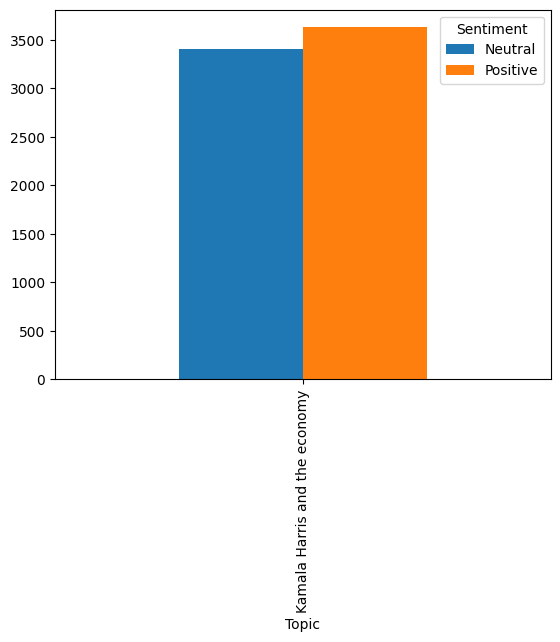

In [62]:
plot_sentiment_likes_by_topic(TRY_DF)

If inference ever fails due to an OutOfMemoryError:
1. Replace the contents of the cell with 1/0 which will delete the exception (Jupyter holds on to a reference to all variables that caused the exception,
so memory will not be freed otherwise).
2. Run this code:

In [ ]:
# gc.collect()
# torch.cuda.empty_cache()

3. You may have to run the cell that errored out another time to get Jupyter to release the variables associated with the exception.

## Full Dataset Run: Run Inference on All Topics

This section takes your prompts for each topic and runs inference on them all.

You likely won't run this yourselves. We will run this when running your code on the VM, and send you the results.

### Run inference

In [ ]:
for topic in SENTIMENT_TOPICS_AND_PROMPTS:
    llama_instruct_inference_on_df_for_topic(model, tokenizer, reddit_df, topic)
    llama_instruct_inference_on_df_for_topic(model, tokenizer, youtube_df, topic)
    break

<!-- #### Save inference output from sentiment back to original dataframes -->

### Extract data from inference output

In [ ]:
for topic in SENTIMENT_TOPICS_AND_PROMPTS:
  extract_sentiment_from_inference_output(reddit_df, topic)
  extract_sentiment_from_inference_output(youtube_df, topic)
  break

<!-- ### Save inference output from sentiment back to original dataframes -->

## Graph and Save Results

This section produces some visualizations of your data and saves them, along with your After you've run inference, run these cells to save your inference output and create a visualization of your data.

### Save raw output to CSV

In [ ]:
youtube_df.to_csv("youtube.csv")
reddit_df.to_csv("reddit.csv")

### Graph likes by sentiment

This code produces graphs that map the like counts of each Reddit and YouTube comment.

In [ ]:
def plot_sentiment_likes_by_topic(df):
    """
    df = join_youtube_dfs(<...>)

    llama_instruct_inference_on_df_for_topic(model, df)
    """


    TOPICS_IN_DF = [topic for topic in SENTIMENT_TOPICS_AND_PROMPTS if topic in df]

    likes_by_topic_by_sentiment = df.melt(id_vars="likes", value_vars=TOPICS_IN_DF, var_name="Topic", value_name="Sentiment").dropna()

    like_sum_by_sentiment_by_topic = likes_by_topic_by_sentiment \
    .groupby(["Sentiment", "Topic"])["likes"] \
    .sum() \
    .reset_index() \
    .pivot(index="Topic", columns="Sentiment", values="likes") \

    like_sum_by_sentiment_by_topic[like_sum_by_sentiment_by_topic.columns.intersection(["Negative", "Neutral", "Positive"])] \
    .plot(kind="bar")


In [ ]:

plot_sentiment_likes_by_topic(reddit_df)
plt.suptitle("Upvotes on Reddit comments, grouped by sentiment towards topics")
plt.ylabel("Total Upvotes")
plt.savefig("reddit_upvotes_grouped_by_sentiment.png", bbox_inches="tight")

plot_sentiment_likes_by_topic(youtube_df)
plt.suptitle("Likes on YouTube comments, grouped by sentiment towards topics")
plt.ylabel("Total Likes")
plt.savefig("youtube_likes_grouped_by_sentiment.png", bbox_inches="tight")

plot_sentiment_comment_count_by_topic(reddit_df)
plt.suptitle("Comment count of Reddit comments, grouped by sentiment towards topics")
plt.ylabel("Total number of comments")
plt.savefig("reddit_comments_grouped_by_sentiment.png", bbox_inches="tight")

plot_sentiment_comment_count_by_topic(youtube_df)
plt.suptitle("Comment count of YouTube comments, grouped by sentiment towards topics")
plt.ylabel("Total number of comments")
plt.savefig("youtube_comments_grouped_by_sentiment.png", bbox_inches="tight")

## Report (YOUR WORK HERE)

Provide a brief answer (ideally < 1 paragraph each, up to 2) to the following questions:

1. Explain your method for data collection (What search terms did you use? What subreddits did you analyze?) Why did you choose this method?
2. Pick 1 or more of the prompting techniques you used. How well did it work? Can you use your knowledge of how LLMs work to explain why?
3. As you ran your code each day, how did sentiment about your candidate toward your selected issue(s) change?

## Fine-tune (EXTRA)

You've likely noticed by this point that, with prompt engineering, there is an upper limit to how well we can do.

Few-shot and Chain of Thought show better results, but they come at the cost of increasing the number of tokens in the prompt. Sometimes, this means the model can miss small details! And, because they take up more tokens, our batch size has to come down in order to fit on a GPU, meaning we lose on parallelism.

Fine-tuning is a process by which the weights of an LLM are slightly tweaked in order to modify the output. With modern techniques, the results can be shocking.

Follow the instructions in fine_tune.ipynb to fine-tune your model.